# Machine Learning Classifier for Dementia Prediction
### Sofiya Patra
In this notebook, I will use machine learning to predict the presence of dementia in patients based on their MRI data. This data was obtained from the Kaggle MRI and Alzheimer's dataset but originated from the Open Access Series of Imaging Studies (OASIS) database. I will be looking at the Cross-sectional MRI data in Young, Middle Aged, Nondemented and Demented Older Adults.

The dataset includes information about Age, Education, Socioeconomic Status, Mini-Mental State Examination (MMSE) score, estimated total intracranial volume, and normalized whole brain volume.

In [22]:
#Importing Libraries
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Pre-processing 
Aim to inspect the data and deal with nulls. 

In [23]:
#read in data
df = pd.read_csv("oasis_cross-sectional.csv")

#inspect data 
print(df.dtypes)
print(df.info())
df.head()


ID        object
M/F       object
Hand      object
Age        int64
Educ     float64
SES      float64
MMSE     float64
CDR      float64
eTIV       int64
nWBV     float64
ASF      float64
Delay    float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
None


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


The target variable is CDR so the rows without CDR are dropped. The ID column is dropped because it is uninformative. The Delay column is dropped because it is mostly null and should not be informative. 

In [24]:
df_clean = df.dropna(subset=["CDR"]).copy()

#drop unnecesary columns
df_clean = df_clean.drop(columns =["ID", "Delay"])

print(df_clean.info())


<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 0 to 415
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     235 non-null    object 
 1   Hand    235 non-null    object 
 2   Age     235 non-null    int64  
 3   Educ    235 non-null    float64
 4   SES     216 non-null    float64
 5   MMSE    235 non-null    float64
 6   CDR     235 non-null    float64
 7   eTIV    235 non-null    int64  
 8   nWBV    235 non-null    float64
 9   ASF     235 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 20.2+ KB
None


Dropping the rows without CDR left nulls only in the SES column. We can impute these using the median. 

In [25]:
#Fill remaining nulls with median
df_clean["SES"].fillna(df_clean["SES"].median(), inplace = True)

#Convert sex and handedness to categorical variables
df_clean["M/F"] = df_clean["M/F"].map({"M": 0, "F": 1})  #Male = 0, Female = 1
df_clean["Hand"] = df_clean["Hand"].map({"R":0, "L":1}) #Right-handed=0, Left-handed = 1

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 0 to 415
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M/F     235 non-null    int64  
 1   Hand    235 non-null    int64  
 2   Age     235 non-null    int64  
 3   Educ    235 non-null    float64
 4   SES     235 non-null    float64
 5   MMSE    235 non-null    float64
 6   CDR     235 non-null    float64
 7   eTIV    235 non-null    int64  
 8   nWBV    235 non-null    float64
 9   ASF     235 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 20.2 KB


/var/folders/1_/t5xhcy1j43g904n29zrnns5h0000gn/T/ipykernel_657/1518214399.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean["SES"].fillna(df_clean["SES"].median(), inplace = True)


Imbalances in the distribution of meaningful variables can cause classifier performance bias. For this reason, the distributions of key variables should be inspected. 

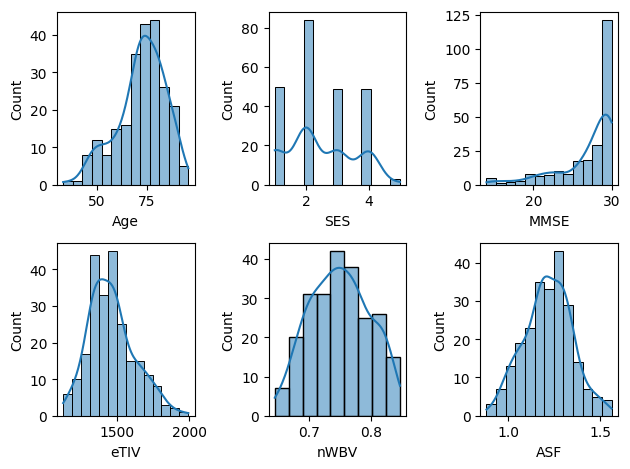

In [26]:
#Continuous variables distributions
plt.subplot(2,3,1)
sns.histplot(df_clean["Age"], kde=True)


plt.subplot(2,3,2)
sns.histplot(df_clean["SES"], kde=True)


plt.subplot(2,3,3)
sns.histplot(df_clean["MMSE"], kde=True)


plt.subplot(2,3,4)
sns.histplot(df_clean["eTIV"], kde=True)


plt.subplot(2,3,5)
sns.histplot(df_clean["nWBV"], kde=True)

plt.subplot(2,3,6)
sns.histplot(df_clean["ASF"], kde=True)

plt.tight_layout()



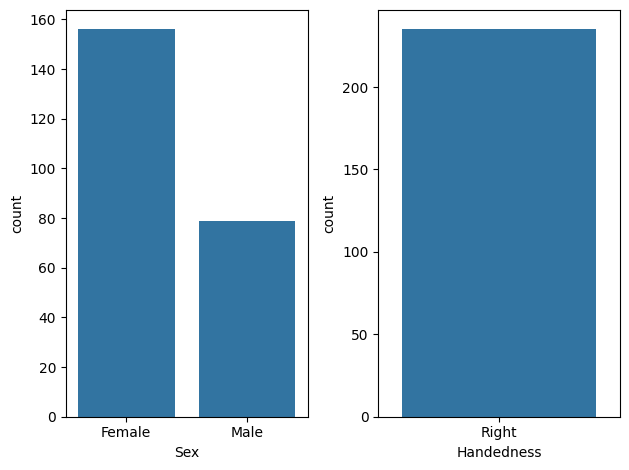

In [27]:
plt.subplot(1,2,1)
sns.countplot(x=df_clean['M/F'].replace({0: 'Male', 1: 'Female'}))
plt.xlabel('Sex')

plt.subplot(1,2,2)
sns.countplot(x=df_clean['Hand'].replace({0: 'Right', 1:'Left'}))
plt.xlabel('Handedness')
plt.tight_layout()

Based on the distributions - there's an imbalance in sex with almost twice the amount of females compared to males. This can lead to bias in the classifier so needs to be considered in the downstream implementation. Additionally, all the subjects are right handed so the Hand column should be removed as it is uninformative. 

In [28]:
df_clean = df_clean.drop(columns=['Hand'])

### Building Classifiers

#### Logistic Regression
The Clinical Dementia Rating (CDR) column has the values 0, 0.5, 1, or 2. In order to use logistic regression we need discrete classes. To do this, I create a new column that makes the rating binary with 0 = nondemented and all other values signifying dementia. I will then use this as the target and train and test the data for the logistic regression as such. Additionally, the MMSE score could be a proxy for CDR so I decided to exclude it from the features. 

In [29]:
df_clean["CDR_binary"] = (df_clean["CDR"] > 0).astype(int)

In [30]:
#defining features and target 
X = df_clean[['Age', 'Educ', 'SES', 'eTIV', 'nWBV', 'ASF']]
y = df_clean['CDR_binary']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)


#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [31]:
log_classifier = LogisticRegression(class_weight='balanced', random_state=42)
log_classifier.fit(X_train_scaled, y_train)

y_pred = log_classifier.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8297872340425532
[[23  4]
 [ 4 16]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.80      0.80      0.80        20

    accuracy                           0.83        47
   macro avg       0.83      0.83      0.83        47
weighted avg       0.83      0.83      0.83        47



#### Random Forest 
Random Forest can classify into multiple categories. However, to make the RandomForestClassifier interpret the CDR values as categories I convert them to strings. Scaling is not needed as it is based on decision trees not distances. 


In [32]:
#defining features and target 
X = df_clean[['Age', 'Educ', 'SES', 'eTIV', 'nWBV', 'ASF']]
y = df_clean['CDR'].astype(str)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

#create classifier
rf_classifier=RandomForestClassifier(n_estimators=100, random_state=42)

#train
rf_classifier.fit(X_train, y_train)

#test
y_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6382978723404256
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79        27
         0.5       0.47      0.50      0.48        14
         1.0       0.33      0.33      0.33         6

    accuracy                           0.64        47
   macro avg       0.54      0.54      0.54        47
weighted avg       0.65      0.64      0.64        47

